# Natural Language Processing

## Get to the Point 

This notebook implements model proposed in the paper: [Get to the Point](https://arxiv.org/abs/1704.04368) which is probably one of the most famous paper during that time.  Even today, people is using this pointer-generator architecture as one component in their model.    Btw, if you forget, you may want to read our lecture where we discuss this paper, or you can also encourage to read the paper once before doing this together.

Source:
- https://github.com/abisee/pointer-generator
- https://github.com/atulkum/pointer_summarizer
- https://github.com/laihuiyuan/pointer-generator

In [1]:
import torch
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import csv, queue, random, time, glob, struct, time, os, math
import numpy as np

from tensorflow.core.example import example_pb2
from threading import Thread
import logging

import pyrouge

logger = logging.getLogger('chaky_logger')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

2023-02-15 12:18:53.223076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


cpu


In [2]:
# torch.cuda.get_device_name(0)

## 0. Config variables

In [3]:
SENTENCE_STA = '<s>'
SENTENCE_END = '</s>'

UNK = 0
PAD = 1
BOS = 2
EOS = 3

PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'
BOS_TOKEN = '[BOS]'
EOS_TOKEN = '[EOS]'

beam_size=4
emb_dim= 128
batch_size= 16
hidden_dim= 256
max_enc_steps=400
max_dec_steps=100
max_tes_steps=100
min_dec_steps=35
vocab_size=50000

lr=0.15
cov_loss_wt = 1.0
pointer_gen = True
is_coverage = True

max_grad_norm=2.0
adagrad_init_acc=0.1
rand_unif_init_mag=0.02
trunc_norm_init_std=1e-4

eps = 1e-12
use_gpu=True
lr_coverage=0.15
max_iterations = 5 #500000

log_root = "data/log/"

train_data_path  = "data/finished_files/chunked/train_*"
eval_data_path   = "data/finished_files/val.bin"
decode_data_path = "data/finished_files/test.bin"
vocab_path       = "data/finished_files/vocab"


## 1. Download data

Go to https://github.com/JafferWilson/Process-Data-of-CNN-DailyMail and download `FINISHED_FILES`.  This is basically tokenized form of cnn news summaries and dailymail summaries. 

## 2. Tokenization

Since things are tokenized, we can skip!  Yay!

## 3. Numericalize

We gonna load our data, check for unique vocabs, and numericalize them.

To help our numericalization, we gonna made the `Vocab` object that gonna help us handle things.  Most of the code is quite self-explanatory.

In [4]:
class Vocab(object):

    def __init__(self, file, max_size):
        self.word2idx = {}
        self.idx2word = {}
        self.count = 0     # keeps track of total number of words in the Vocab

        # [UNK], [PAD], [BOS] and [EOS] get the ids 0,1,2,3.
        for w in [UNK_TOKEN, PAD_TOKEN, BOS_TOKEN, EOS_TOKEN]:
            self.word2idx[w] = self.count
            self.idx2word[self.count] = w
            self.count += 1

        # Read the vocab file and add words up to max_size
        with open(file, 'r') as fin:
            for line in fin:
                items = line.split()
                if len(items) != 2:
                    print('Warning: incorrectly formatted line in vocabulary file: %s' % line.strip())
                    continue
                w = items[0]
                if w in [SENTENCE_STA, SENTENCE_END, UNK_TOKEN, PAD_TOKEN, BOS_TOKEN, EOS_TOKEN]:
                    raise Exception(
                        '<s>, </s>, [UNK], [PAD], [BOS] and [EOS] shouldn\'t be in the vocab file, but %s is' % w)
                if w in self.word2idx:
                    raise Exception('Duplicated word in vocabulary file: %s' % w)
                self.word2idx[w] = self.count
                self.idx2word[self.count] = w
                self.count += 1
                if max_size != 0 and self.count >= max_size:
                    break
        print("Finished constructing vocabulary of %i total words. Last word added: %s" % (
          self.count, self.idx2word[self.count - 1]))

    def word2id(self, word):
        if word not in self.word2idx:
            return self.word2idx[UNK_TOKEN]
        return self.word2idx[word]

    def id2word(self, word_id):
        if word_id not in self.idx2word:
            raise ValueError('Id not found in vocab: %d' % word_id)
        return self.idx2word[word_id]

    def size(self):
        return self.count

### Testing the Vocab class

In [5]:
vocab = Vocab(vocab_path, vocab_size)

Finished constructing vocabulary of 50000 total words. Last word added: perisic


In [6]:
vocab.word2id("the")

5

In [7]:
vocab.id2word(5)

'the'

## 4. Prepare batch loader

### 4.1 Example

First we will write the `Example` class.  A very simple class that will help hold a pair of article and the label abstract.  Just one pair (thus we called `Example`).

Here, 
1. We first decode both the article and abstract (from bytes to strings) (bytes are store in .bin which is a more efficient way)
2. We create the `enc_inp` to store the encoder input from the article, which is simply ids which we convert by using the `vocab.word2id`
3. We create the `dec_inp` and `tgt` from the abstract which is also ids which we convert through `vocab.word2id`.  The difference of `dec_inp` and `tgt` is that they are one words away, i.e., `tgt` will have `SOS token` added in front, for decoding purpose
4. If we plan to use the pointer and generator mode, we need to store a version of the `enc_input` and `tgt` which knows the oov and assign unique id for each oov.  Later it will make sense.

Note that both `enc_inp`, `dec_inp` and `tgt` are truncated based on `max_en_steps` and `max_dec_steps` respectively.

In [8]:
class Example(object):

    def __init__(self, article, abstract_sentences, vocab):
        # Get ids of special tokens
        bos_decoding = vocab.word2id(BOS_TOKEN)
        eos_decoding = vocab.word2id(EOS_TOKEN)

        # Process the article
        article_words = article.decode().split()
        if len(article_words) > max_enc_steps:
            article_words = article_words[:max_enc_steps]
        self.enc_len = len(article_words)  # store the length after truncation but before padding
        self.enc_inp = [vocab.word2id(w) for w in
                          article_words]   # list of word ids; OOVs are represented by the id for UNK token

        # Process the abstract, converting bytes to unicode
        abstract = ' '.encode().join(abstract_sentences).decode()        
        abstract_words = abstract.split()  # list of strings
        abs_ids = [vocab.word2id(w) for w in abstract_words]  # list of word ids; OOVs are represented by the id for UNK token

        # Get the decoder input sequence and target sequence
        self.dec_inp, self.tgt = self.get_dec_seq(abs_ids, max_dec_steps, bos_decoding, eos_decoding)        
        self.dec_len = len(self.dec_inp)

        # If using pointer-generator mode, we need to store some extra info
        if pointer_gen:
            # Store a version of the enc_input where in-article OOVs are represented by their temporary OOV id;
            # also store the in-article OOVs words themselves
            self.enc_inp_extend_vocab, self.article_oovs = article2ids(article_words, vocab)

            # Get a verison of the reference summary where in-article OOVs are represented by their temporary article OOV id
            abs_ids_extend_vocab = abstract2ids(abstract_words, vocab, self.article_oovs)

            # Overwrite decoder target sequence so it uses the temp article OOV ids
            _, self.tgt = self.get_dec_seq(abs_ids_extend_vocab, max_dec_steps, bos_decoding, eos_decoding)

        # Store the original strings
        self.original_article  = article
        self.original_abstract = abstract
        self.original_abstract_sents = abstract_sentences

    def get_dec_seq(self, sequence, max_len, start_id, stop_id):
        src = [start_id] + sequence[:]
        tgt = sequence[:]
        if len(src) > max_len:   # truncate
            src = src[:max_len]
            tgt = tgt[:max_len]  # no end_token
        else:  # no truncation
            tgt.append(stop_id)  # end token
        assert len(src) == len(tgt)
        return src, tgt

    #this is for padding; used for Batch class....
    #basically take the max_len of the batch, and pad all sentences to that length
    def pad_enc_seq(self, max_len, pad_id):
        while len(self.enc_inp) < max_len:
            self.enc_inp.append(pad_id)
        if pointer_gen:
            while len(self.enc_inp_extend_vocab) < max_len:
                self.enc_inp_extend_vocab.append(pad_id)

    #same
    def pad_dec_seq(self, max_len, pad_id):
        while len(self.dec_inp) < max_len:
            self.dec_inp.append(pad_id)
        while len(self.tgt) < max_len:
            self.tgt.append(pad_id)
            
### utility functions

#converting abstract to ids
def abstract2ids(abstract_words, vocab, article_oovs):
    ids = []
    unk_id = vocab.word2id(UNK_TOKEN)
    for w in abstract_words:
        i = vocab.word2id(w)
        if i == unk_id:  # If w is an OOV word
            if w in article_oovs:  # If w is an in-article OOV
                vocab_idx = vocab.size() + article_oovs.index(w)  # Map to its temporary article OOV number
                ids.append(vocab_idx)
            else:  # If w is an out-of-article OOV
                ids.append(unk_id)  # Map to the UNK token id
        else:
            ids.append(i)
    return ids

#converting article to ids
def article2ids(article_words, vocab):
    ids = []
    oov = []
    unk_id = vocab.word2id(UNK_TOKEN)
    for w in article_words:
        i = vocab.word2id(w)
        if i == unk_id:  # If w is OOV
            if w not in oov:  # Add to list of OOVs
                oov.append(w)
            oov_num = oov.index(w)  # This is 0 for the first article OOV, 1 for the second article OOV...
            ids.append(vocab.size() + oov_num)  # This is e.g. 50000 for the first article OOV, 50001 for the second...
        else:
            ids.append(i)
    return ids, oov


### Testing the Example

Our code used bytes for efficiency.  When we want to convert it back to unicode, we use `decode()`.

In [9]:
article = b"the real wolf Chaky of wall has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . jordan belfort , who is played by leonardo dicaprio in the oscar-nominated film , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars of savings . ` it was about a month in when i realized . that was the first moment where i allowed greed to get the better of me , ' he told piers morgan live . scroll down for video . soulless : the real wolf of wall street , jordan belfort , pictured monday night , has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . belfort , 51 , who is now a motivational speaker , applauded the movie , and said he spent more than 100 hours with dicaprio , helping him prepare for the role of his life . he praised the actor for making the film what he calls a cautionary tale rather than glorifying the excessive behavior , as many critics have claimed the film does ."
type(article)

bytes

In [10]:
abstract_sentences = [b'jordan belfort , Chaky who is played by leonardo dicaprio , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars .', b'belfort , 51 , who is now a motivational speaker , applauded the wolf of wall street , but said it was difficult to watch in parts .', b'he said he spent more than 100 hours helping dicaprio prepare for the role of his life .', b'the man who spent 22 months in prison for securities fraud and money laundering insisted to piers morgan that 95 per cent of what he did was legal .', b"but he added ` the 5 per cent was incredibly destructive and it poisoned everything '"]
len(abstract_sentences)

5

In [11]:
example = Example(article, abstract_sentences, vocab)

In [12]:
#looking at encoder input
for id in example.enc_inp:
    print(vocab.id2word(id), end=" ")

the real wolf [UNK] of wall has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . jordan belfort , who is played by leonardo dicaprio in the oscar-nominated film , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars of savings . ` it was about a month in when i realized . that was the first moment where i allowed greed to get the better of me , ' he told piers morgan live . scroll down for video . soulless : the real wolf of wall street , jordan belfort , pictured monday night , has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . belfort , 51 , who is now a motivational speaker , applauded the movie , and said he spent more than 100 hours with dicaprio , helping him prepare for the rol

In [13]:
#looking at decoder input (it's truncated based on max_dec_steps)
for id in example.dec_inp:
    print(vocab.id2word(id), end=" ")

[BOS] jordan belfort , [UNK] who is played by leonardo dicaprio , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars . belfort , 51 , who is now a motivational speaker , applauded the wolf of wall street , but said it was difficult to watch in parts . he said he spent more than 100 hours helping dicaprio prepare for the role of his life . the man who spent 22 months in prison for securities fraud and money laundering insisted to piers 

In [14]:
#looking at tgt (it's basically one more ahead of input, since we are using teaching forcing)
for id in example.tgt:
    try:
        print(vocab.id2word(id), end=" ")
    except:
        print("Unknown id", id)
        continue

jordan belfort , Unknown id 50000
who is played by leonardo dicaprio , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars . belfort , 51 , who is now a motivational speaker , applauded the wolf of wall street , but said it was difficult to watch in parts . he said he spent more than 100 hours helping dicaprio prepare for the role of his life . the man who spent 22 months in prison for securities fraud and money laundering insisted to piers morgan 

In [15]:
#looking at our the example know which is the oov in article
example.article_oovs

['Chaky']

In [16]:
#any oov will get id 50000, 500001, etc.  Since I have only Chaky, it is 50000
example.enc_inp_extend_vocab[3] #belongs to "Chaky"

50000

In [17]:
#if the tgt also has Chaky, it will also assign the same id 50000
example.tgt[3] #belongs to Chaky

50000

### 4.2 Batch

Let's create a class `Batch` for holding a list of `Example`.

In this class, what it will do is:

1.  Determine the max length of sentence in the batch
2.  Then pad according to this max length
3.  Then create empty numpy arrays of shape `enc_batch`:`(batch_size, max_len)`, `enc_lens`: `(batch_size, )`, and `enc_padding_mask`:`(batch_size, max_len)` and populate accordingly
4.  This is done in the same manner for `dec_batch`, `tgt_batch`, `dec_padding_mask`, and `dec_lens`

Note that `lens` are needed when we do padding, so that the model knows the original length.

In [18]:
class Batch(object):
    def __init__(self, example_list, vocab, batch_size):
        self.batch_size = batch_size
        self.pad_id = vocab.word2id(PAD_TOKEN)  # id of the PAD token used to pad sequences
        self.init_encoder_seq(example_list)  # initialize the input to the encoder
        self.init_decoder_seq(example_list)  # initialize the input and targets for the decoder
        self.store_orig_strings(example_list)  # store the original strings

    def init_encoder_seq(self, example_list):
        # Determine the maximum length of the encoder input sequence in this batch
        max_enc_seq_len = max([ex.enc_len for ex in example_list])

        # Pad the encoder input sequences up to the length of the longest sequence
        for ex in example_list:
            ex.pad_enc_seq(max_enc_seq_len, self.pad_id)

        # Initialize the numpy arrays
        # Note: our enc_batch can have different length (second dimension) for each batch because we use dynamic_rnn for the encoder.
        self.enc_batch = np.zeros((self.batch_size, max_enc_seq_len), dtype=np.int32)
        self.enc_lens = np.zeros((self.batch_size), dtype=np.int32)
        self.enc_padding_mask = np.zeros((self.batch_size, max_enc_seq_len), dtype=np.float32)  #basically [1, 1, 1, 1, 1, 0, 0, ..] where 0 indicates that that pos is a padding

        # Fill in the numpy arrays
        for i, ex in enumerate(example_list):
            self.enc_batch[i, :] = ex.enc_inp[:]
            self.enc_lens[i] = ex.enc_len
            for j in range(ex.enc_len):
                self.enc_padding_mask[i][j] = 1

        # For pointer-generator mode, need to store some extra info
        if pointer_gen:
            # Determine the max number of in-article OOVs in this batch
            self.max_art_oovs = max([len(ex.article_oovs) for ex in example_list])
            # Store the in-article OOVs themselves
            self.art_oovs = [ex.article_oovs for ex in example_list]
            # Store the version of the enc_batch that uses the article OOV ids
            self.enc_batch_extend_vocab = np.zeros((self.batch_size, max_enc_seq_len), dtype=np.int32)
            for i, ex in enumerate(example_list):
                self.enc_batch_extend_vocab[i, :] = ex.enc_inp_extend_vocab[:]

    def init_decoder_seq(self, example_list):
        # Pad the inputs and targets
        for ex in example_list:
            ex.pad_dec_seq(max_dec_steps, self.pad_id)

        # Initialize the numpy arrays.
        self.dec_batch = np.zeros((self.batch_size, max_dec_steps), dtype=np.int32)
        self.tgt_batch = np.zeros((self.batch_size, max_dec_steps), dtype=np.int32)
        self.dec_padding_mask = np.zeros((self.batch_size, max_dec_steps), dtype=np.float32)
        self.dec_lens = np.zeros((self.batch_size), dtype=np.int32)

        # Fill in the numpy arrays
        for i, ex in enumerate(example_list):
            self.dec_batch[i, :] = ex.dec_inp[:]
            self.tgt_batch[i, :] = ex.tgt[:]
            self.dec_lens[i] = ex.dec_len
            for j in range(ex.dec_len):
                self.dec_padding_mask[i][j] = 1

    def store_orig_strings(self, example_list):
        self.original_articles = [ex.original_article for ex in example_list]  # list of lists
        self.original_abstracts = [ex.original_abstract for ex in example_list]  # list of lists
        self.original_abstracts_sents = [ex.original_abstract_sents for ex in example_list]  # list of list of lists

### Testing the Batch

In [19]:
article = b"the real wolf Chaky of wall has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . jordan belfort , who is played by leonardo dicaprio in the oscar-nominated film , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars of savings . ` it was about a month in when i realized . that was the first moment where i allowed greed to get the better of me , ' he told piers morgan live . scroll down for video . soulless : the real wolf of wall street , jordan belfort , pictured monday night , has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . belfort , 51 , who is now a motivational speaker , applauded the movie , and said he spent more than 100 hours with dicaprio , helping him prepare for the role of his life . he praised the actor for making the film what he calls a cautionary tale rather than glorifying the excessive behavior , as many critics have claimed the film does ."
abstract_sentences = [b'jordan belfort , Chaky who is played by leonardo dicaprio , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars .', b'belfort , 51 , who is now a motivational speaker , applauded the wolf of wall street , but said it was difficult to watch in parts .', b'he said he spent more than 100 hours helping dicaprio prepare for the role of his life .', b'the man who spent 22 months in prison for securities fraud and money laundering insisted to piers morgan that 95 per cent of what he did was legal .', b"but he added ` the 5 per cent was incredibly destructive and it poisoned everything '"]
example1 = Example(article, abstract_sentences, vocab)

article2 = b"person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . jordan belfort , who is played by leonardo dicaprio in the oscar-nominated film , described in a monday night interview the moment he learned he was selling a scam , cheating innocent people out of millions of dollars of savings . ` it was about a month in when i realized . that was the first moment where i allowed greed to get the better of me , ' he told piers morgan live . scroll down for video . soulless : the real wolf of wall street , jordan belfort , pictured monday night , has admitted he lost his soul ` as much as a person can and still be walking around ' in the midst of his wheeling and dealing and debauched life of 90 's excess . belfort , 51 , who is now a motivational speaker , applauded the movie , and said he spent more than 100 hours with dicaprio , helping him prepare for the role of his life . he praised the actor for making the film what he calls a cautionary tale rather than glorifying the excessive behavior , as many critics have claimed the film does ."
abstract_sentences2 = [b'he learned he was selling a scam , cheating innocent people out of millions of dollars .', b'belfort , 51 , who is now a motivational speaker , applauded the wolf of wall street , but said it was difficult to watch in parts .', b'he said he spent more than 100 hours helping dicaprio prepare for the role of his life .', b'the man who spent 22 months in prison for securities fraud and money laundering insisted to piers morgan that 95 per cent of what he did was legal .', b"but he added ` the 5 per cent was incredibly destructive and it poisoned everything '"]
example2 = Example(article, abstract_sentences, vocab)


In [20]:
batch_size = 3

b = [example1, example2]
Batch(b, vocab, batch_size)

### 4.3 Batcher

This is a very simple `Batcher` for providing batches of data for training, testing, etc.  It uses `Thread` and `Queue` for simultaneously reading data and putting them into the queue for high efficiency. 

Aside from that, it just output a batch of `(articles, abstracts)`.

In [21]:
class Batcher(object):
    BATCH_QUEUE_MAX = 100  # max number of batches the batch_queue can hold

    def __init__(self, vocab, data_path, batch_size, single_pass, mode):
        self._vocab = vocab
        self._data_path = data_path
        self.batch_size = batch_size
        self.single_pass = single_pass
        self.mode = mode

        # Initialize a queue of Batches waiting to be used, and a queue of Examples waiting to be batched
        self._batch_queue   = queue.Queue(self.BATCH_QUEUE_MAX)
        self._example_queue = queue.Queue(self.BATCH_QUEUE_MAX * self.batch_size)

        # Different settings depending on whether we're in single_pass mode or not
        if single_pass:
            self._num_example_q_threads = 1  # just one thread, so we read through the dataset just once
            self._num_batch_q_threads = 1    # just one thread to batch examples
            self._bucketing_cache_size = 1   # only load one batch's worth of examples before bucketing
            self._finished_reading = False   # this will tell us when we're finished reading the dataset
        else:
            self._num_example_q_threads = 1  # num threads to fill example queue
            self._num_batch_q_threads = 1    # num threads to fill batch queue
            self._bucketing_cache_size = 1   # how many batches-worth of examples to load into cache before bucketing

        # Start the threads that load the queues
        self._example_q_threads = []
        for _ in range(self._num_example_q_threads):
            self._example_q_threads.append(Thread(target=self.fill_example_queue))
            self._example_q_threads[-1].daemon = True
            self._example_q_threads[-1].start()
        self._batch_q_threads = []
        for _ in range(self._num_batch_q_threads):
            self._batch_q_threads.append(Thread(target=self.fill_batch_queue))
            self._batch_q_threads[-1].daemon = True
            self._batch_q_threads[-1].start()

        # Start a thread that watches the other threads and restarts them if they're dead
        if not single_pass:                   # We don't want a watcher in single_pass mode because the threads shouldn't run forever
            self._watch_thread = Thread(target=self.watch_threads)
            self._watch_thread.daemon = True
            self._watch_thread.start()

    def next_batch(self):
        # If the batch queue is empty, print a warning
        if self._batch_queue.qsize() == 0:
            logger.warning(
                'Bucket input queue is empty when calling next_batch. Bucket queue size: %i, Input queue size: %i',
                self._batch_queue.qsize(), self._example_queue.qsize())
            if self.single_pass and self._finished_reading:
                logger.info("Finished reading dataset in single_pass mode.")
                return None

        batch = self._batch_queue.get()  # get the next Batch
        return batch

    def fill_example_queue(self):
        example_generator = self.example_generator(self._data_path, self.single_pass)
        input_gen = self.pair_generator(example_generator)

        while True:
            try:
                (article,
                 abstract) = input_gen.__next__()  # read the next example from file. article and abstract are both strings.
            except StopIteration:  # if there are no more examples:
                logger.info("The example generator for this example queue filling thread has exhausted data.")
                if self.single_pass:
                    logger.info(
                        "single_pass mode is on, so we've finished reading dataset. This thread is stopping.")
                    self._finished_reading = True
                    break
                else:
                    raise Exception("single_pass mode is off but the example generator is out of data; error.")

            abstract_sentences = [sent.strip() for sent in abstract2sents(
                abstract)]  # Use the <s> and </s> tags in abstract to get a list of sentences.
        
            example = Example(article, abstract_sentences, self._vocab)
            self._example_queue.put(example)

    def fill_batch_queue(self):
        while True:
            if self.mode == 'decode':
                # beam search decode mode single example repeated in the batch
                ex = self._example_queue.get()
                b = [ex for _ in range(self.batch_size)]
                self._batch_queue.put(Batch(b, self._vocab, self.batch_size))
            else:
                # Get bucketing_cache_size-many batches of Examples into a list, then sort
                inputs = []
                for _ in range(self.batch_size * self._bucketing_cache_size):
                    inputs.append(self._example_queue.get())
                inputs = sorted(inputs, key=lambda inp: inp.enc_len, reverse=True)  # sort by length of encoder sequence

                # Group the sorted Examples into batches, optionally shuffle the batches, and place in the batch queue.
                batches = []
                for i in range(0, len(inputs), self.batch_size):
                    batches.append(inputs[i:i + self.batch_size])
                if not self.single_pass:
                    random.shuffle(batches)
                for b in batches:  # each b is a list of Example objects
                    self._batch_queue.put(Batch(b, self._vocab, self.batch_size))

    def watch_threads(self):
        while True:
            logger.info(
                'Bucket queue size: %i, Input queue size: %i',
                self._batch_queue.qsize(), self._example_queue.qsize())

            time.sleep(60)
            for idx, t in enumerate(self._example_q_threads):
                if not t.is_alive():  # if the thread is dead
                    logger.error('Found example queue thread dead. Restarting.')
                    new_t = Thread(target=self.fill_example_queue)
                    self._example_q_threads[idx] = new_t
                    new_t.daemon = True
                    new_t.start()
            for idx, t in enumerate(self._batch_q_threads):
                if not t.is_alive():  # if the thread is dead
                    logger.error('Found batch queue thread dead. Restarting.')
                    new_t = Thread(target=self.fill_batch_queue)
                    self._batch_q_threads[idx] = new_t
                    new_t.daemon = True
                    new_t.start()

    def pair_generator(self, example_generator):
        while True:
            e = example_generator.__next__()  # e is a tf.Example
            try:
                article_text = e.features.feature['article'].bytes_list.value[
                    0]  # the article text was saved under the key 'article' in the data files
                abstract_text = e.features.feature['abstract'].bytes_list.value[
                    0]  # the abstract text was saved under the key 'abstract' in the data files
            except ValueError:
                logger.error('Failed to get article or abstract from example')
                continue
            if len(article_text) == 0:  # See https://github.com/abisee/pointer-generator/issues/1
                # logger.warning('Found an example with empty article text. Skipping it.')
                continue
            else:
                yield (article_text, abstract_text)

    def example_generator(self, data_path, single_pass):
        while True:
            filelist = glob.glob(data_path)  # get the list of datafiles
            assert filelist, ('Error: Empty filelist at %s' % data_path)  # check filelist isn't empty
            if single_pass:
                filelist = sorted(filelist)
            else:
                random.shuffle(filelist)
            for f in filelist:
                reader = open(f, 'rb')
                while True:
                    len_bytes = reader.read(8)
                    if not len_bytes: break  # finished reading this file
                    str_len = struct.unpack('q', len_bytes)[0]  #q stands for integers
                    example_str = struct.unpack('%ds' % str_len, reader.read(str_len))[0]
                    yield example_pb2.Example.FromString(example_str)
            if single_pass:
                print("example_generator completed reading all datafiles. No more data.")
                break
            
### utility functions
    
def abstract2sents(abstract):
    cur_p = 0
    sents = []
    while True:
        try:
            sta_p = abstract.index(SENTENCE_STA.encode(), cur_p)
            end_p = abstract.index(SENTENCE_END.encode(), sta_p + 1)
            cur_p = end_p + len(SENTENCE_END.encode())
            sents.append(abstract[sta_p + len(SENTENCE_STA.encode()):end_p])
        except ValueError as e:  # no more sentences
            return sents

### Testing Batcher

In [22]:
batcher = Batcher(vocab, train_data_path, batch_size, single_pass=False, mode='train')

In [23]:
batch = batcher.next_batch()

In [24]:
enc_lens = batch.enc_lens
enc_lens  #(length of first batch, length of second batch)

array([400, 400, 400], dtype=int32)

In [25]:
enc_batch = torch.from_numpy(batch.enc_batch).long()
enc_batch.shape  #(batch size, seq len)  #seq len is padded to max length thus same length for all samples

torch.Size([3, 400])

In [26]:
enc_padding_mask = torch.from_numpy(batch.enc_padding_mask).float()
enc_padding_mask.shape #(batch size, seq len)  #simply indicates which position is real word or padding

torch.Size([3, 400])

In [27]:
#if pointer_gen:
enc_batch_extend_vocab = torch.from_numpy(batch.enc_batch_extend_vocab).long()
enc_batch_extend_vocab.shape  #(batch size, seq len) #used if we use pointer_gen, which has dedicated ID of oov

torch.Size([3, 400])

In [28]:
#batch.max_art_oovs > 0:
extra_zeros = torch.zeros((batch_size, batch.max_art_oovs))
extra_zeros.shape  #(batch_size, max number of in-article OOVs in this batch)

torch.Size([3, 8])

## 4. Model

<img src = "images/gettothepoint.png" width=800>

### 4.1 Basic Module

The author implements truncated normal distribution to initialize the parameters.  To impose this initialization on all module, they created an abstract class called BasicModule (which then other module will inherits), which implements the truncated normal distribution.

As to why truncated is good is likely related to better activation.  Read this: https://stats.stackexchange.com/questions/228670/what-is-the-benefit-of-the-truncated-normal-distribution-in-initializing-weights

In [29]:
class BasicModule(nn.Module):
    def __init__(self, init='uniform'):
        super(BasicModule, self).__init__()
        self.init = init

    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                if self.init == 'uniform':
                    torch.nn.init.uniform_(param, a=-0.05, b=0.05)
                elif self.init == 'normal':
                    torch.nn.init.normal_(param, std=stddev)
                elif self.init == 'truncated_normal':
                    self.truncated_normal_(param, mean=0,std=stddev)

    def truncated_normal_(self, tensor, mean=0, std=1.):
        """
        Implemented by @ruotianluo
        See https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/15
        """
        size = tensor.shape
        tmp = tensor.new_empty(size + (4,)).normal_()
        valid = (tmp < 2) & (tmp > -2)
        ind = valid.max(-1, keepdim=True)[1]
        tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
        tensor.data.mul_(std).add_(mean)
        return tensor

### Testing the truncated normal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


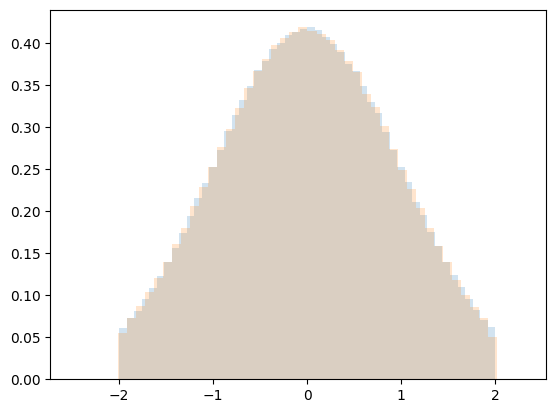

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    return tensor

fig, ax = plt.subplots(1, 1)


def test_truncnorm():
    a, b = -2, 2
    size = 1000000
    r = truncnorm.rvs(a, b, size=size)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=50)

    tensor = torch.zeros(size)
    truncated_normal_(tensor)
    r = tensor.numpy()

    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=50)
    ax.legend(loc='best', frameon=False)
    plt.show()


test_truncnorm()

### 4.2 Attention

In [31]:
class Attention(BasicModule):
    def __init__(self):
        super(Attention, self).__init__()

        self.fc = nn.Linear(hidden_dim * 2, 1, bias=False)
        self.dec_fc = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        if is_coverage:
            self.con_fc = nn.Linear(1, hidden_dim * 2, bias=False)

        self.init_params()

    def forward(self, s_t, enc_out, enc_fea, enc_padding_mask, coverage):
        b, l, n = list(enc_out.size())

        dec_fea = self.dec_fc(s_t)  # B x 2*hidden_dim
        dec_fea_expanded = dec_fea.unsqueeze(1).expand(b, l, n).contiguous()  # B x l x 2*hidden_dim
        dec_fea_expanded = dec_fea_expanded.view(-1, n)     # B*l x 2*hidden_dim

        att_features = enc_fea + dec_fea_expanded           # B*l x 2*hidden_dim
        if is_coverage:
            coverage_inp = coverage.view(-1, 1)             # B*l x 1
            coverage_fea = self.con_fc(coverage_inp)        # B*l x 2*hidden_dim
            att_features = att_features + coverage_fea

        e = torch.tanh(att_features)                        # B*l x 2*hidden_dim
        scores = self.fc(e)                                 # B*l x 1
        scores = scores.view(-1, l)                         # B x l

        attn_dist_ = F.softmax(scores, dim=1) * enc_padding_mask  # B x l
        normalization_factor = attn_dist_.sum(1, keepdim=True)
        attn_dist = attn_dist_ / normalization_factor

        attn_dist = attn_dist.unsqueeze(1)                        # B x 1 x l
        c_t = torch.bmm(attn_dist, enc_out)                       # B x 1 x n
        c_t = c_t.view(-1, hidden_dim * 2)                 # B x 2*hidden_dim

        attn_dist = attn_dist.view(-1, l)                         # B x l

        if is_coverage:
            coverage = coverage.view(-1, l)
            coverage = coverage + attn_dist

        return c_t, attn_dist, coverage

### 4.3 Encoder

A very simple bidrectional LSTM-based encoder, which encodes data using LSTM follow by a simple linear layer that output a hidden state.  It uses `pack_padded_sequence` for efficiency and to ignore paddings.

In [32]:
class Encoder(BasicModule):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_word_emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)

        self.init_params()

    # seq_lens should be in descending order
    def forward(self, input, seq_lens):
        #input: [batch_size, seq len]
        
        embedded = self.src_word_emb(input)  
        #embedded: [batch_size, seq len, emb dim]

        packed = pack_padded_sequence(embedded, seq_lens, batch_first=True)  #efficient sparse matrix, also ignoring padding
        output, hidden = self.lstm(packed)
        #hidden = h, c
        #h: [directions*num_layers, batch size, hidden_dim]
        #c: [directions*num_layers, batch size, hidden_dim]

        encoder_outputs, _ = pad_packed_sequence(output, batch_first=True)
        #encoder_outputs: [batch size, seq len, hidden dim*directions]
        encoder_outputs = encoder_outputs.contiguous()  #contingous so we can view....if we use reshape, no need

        encoder_feature = encoder_outputs.view(-1, 2 * hidden_dim)
        #encoder_feature: [batch size * seq len, hidden dim*directions]
        
        encoder_feature = self.fc(encoder_feature)
        #encoder_feature: [batch size * seq len, hidden dim*directions]

        return encoder_outputs, encoder_feature, hidden


### 4.4 Reduced State

Just a very simple pipe, which reduce the hidden and cell states from `hidden_dim*2` to `hidden_dim`.

In [33]:
class ReduceState(BasicModule):
    def __init__(self):
        super(ReduceState, self).__init__()

        self.reduce_h = nn.Linear(hidden_dim * 2, hidden_dim)
        self.reduce_c = nn.Linear(hidden_dim * 2, hidden_dim)
        self.init_params()


    def forward(self, hidden):
        h, c = hidden
        #h, c: [directions*num_layers, batch size, hidden_dim]

        h_in = h.transpose(0, 1).contiguous().view(-1, hidden_dim * 2)
        #h_in: [batch_size, hidden_dim*direction*num_layers]
        
        hidden_reduced_h = F.relu(self.reduce_h(h_in))
        #hidden_reduced_h: [batch_size, hidden_dim]
        
        c_in = c.transpose(0, 1).contiguous().view(-1, hidden_dim * 2)
        #c_in: [batch_size, hidden_dim*direction*num_layers]
        
        hidden_reduced_c = F.relu(self.reduce_c(c_in))
        #hidden_reduced_c: [batch_size, hidden_dim]

        return (hidden_reduced_h.unsqueeze(0), hidden_reduced_c.unsqueeze(0))  # [1, batch_size, hidden_dim]

### 4.5 Decoder

In [34]:
class Decoder(BasicModule):
    def __init__(self):
        super(Decoder, self).__init__()
        self.attention_network = Attention()
        # decoder
        self.tgt_word_emb = nn.Embedding(vocab_size, emb_dim)
        self.con_fc = nn.Linear(hidden_dim * 2 + emb_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=False)

        if pointer_gen:
            self.p_gen_fc = nn.Linear(hidden_dim * 4 + emb_dim, 1)

        # p_vocab
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

        self.init_params()

    def forward(self, y_t, s_t, enc_out, enc_fea, enc_padding_mask,
                c_t, extra_zeros, enc_batch_extend_vocab, coverage, step):
        
        #y_t:              [batch size]
        #s_t ==> h_t, c_t: [1, batch size, hid dim]  ==> reduced hidden states from encoder
        #enc_out:          [batch size, seq len, hid dim * 2] ==> all hidden states 
        #enc_fea:          [batch size * seq len, hid dim * 2] ==> 2d version of enc_out
        #enc_padding_mask: [batch size, seq len]
        #c_t:              [batch_size, hid dim * 2))
        #extra_zeros:      [batch_size, batch.max_art_oovs] ==> max number of in-article OOVs in this batch
        #enc_batch_extend_vocab: [batch size, seq len] ==> used if we use pointer_gen, which has dedicated ID of oov
        #coverage:         [batch_size, seq len]
        
        if not self.training and step == 0:
            dec_h, dec_c = s_t
            s_t_hat = torch.cat((dec_h.view(-1, hidden_dim),
                                 dec_c.view(-1, hidden_dim)), 1)  # B x 2*hidden_dim
            c_t, _, coverage_next = self.attention_network(s_t_hat, enc_out, enc_fea,
                                                           enc_padding_mask, coverage)
            coverage = coverage_next

        y_t_embd = self.tgt_word_emb(y_t)
        x = self.con_fc(torch.cat((c_t, y_t_embd), 1))
        lstm_out, s_t = self.lstm(x.unsqueeze(1), s_t)

        dec_h, dec_c = s_t
        s_t_hat = torch.cat((dec_h.view(-1, hidden_dim),
                             dec_c.view(-1, hidden_dim)), 1)     # B x 2*hidden_dim
        c_t, attn_dist, coverage_next = self.attention_network(s_t_hat, enc_out, enc_fea,
                                                               enc_padding_mask, coverage)

        if self.training or step > 0:
            coverage = coverage_next

        p_gen = None
        if pointer_gen:
            p_gen_inp = torch.cat((c_t, s_t_hat, x), 1)  # B x (2*2*hidden_dim + emb_dim)
            p_gen = self.p_gen_fc(p_gen_inp)
            p_gen = torch.sigmoid(p_gen)

        output = torch.cat((lstm_out.view(-1, hidden_dim), c_t), 1)  # B x hidden_dim * 3
        output = self.fc1(output)  # B x hidden_dim
        # output = F.relu(output)

        output = self.fc2(output)  # B x vocab_size
        vocab_dist = F.softmax(output, dim=1)

        if pointer_gen:
            vocab_dist_ = p_gen * vocab_dist
            attn_dist_ = (1 - p_gen) * attn_dist

            if extra_zeros is not None:
                vocab_dist_ = torch.cat([vocab_dist_, extra_zeros], 1)

            final_dist = vocab_dist_.scatter_add(1, enc_batch_extend_vocab, attn_dist_)
        else:
            final_dist = vocab_dist

        return final_dist, s_t, c_t, attn_dist, p_gen, coverage

### 4.6 Putting everything together

In [35]:
class Model(object):
    def __init__(self, model_path=None):
        encoder = Encoder()
        decoder = Decoder()
        reduce_state = ReduceState()

        # shared the embedding between encoder and decoder
        decoder.tgt_word_emb.weight = encoder.src_word_emb.weight

        encoder = encoder.to(device)
        decoder = decoder.to(device)
        reduce_state = reduce_state.to(device)

        self.encoder = encoder
        self.decoder = decoder
        self.reduce_state = reduce_state

        if model_path is not None:
            state = torch.load(model_path, map_location=lambda storage, location: storage)
            self.encoder.load_state_dict(state['encoder_state_dict'])
            self.decoder.load_state_dict(state['decoder_state_dict'], strict=False)
            self.reduce_state.load_state_dict(state['reduce_state_dict'])


### Testing the model

In [36]:
#define since above...
batch_size

3

In [37]:
#this is from where we test the Batcher....
enc_batch.shape, enc_lens.shape #[batch size, seq len], [batch size]

(torch.Size([3, 400]), (3,))

### 1. Encoding

In [38]:
#1. encoding inputs
chaky_model = Model()
enc_out, enc_fea, enc_h = chaky_model.encoder(enc_batch, enc_lens)
h, c = enc_h  
enc_out.shape, enc_fea.shape, h.shape, c.shape #[batch size, seq len, hid dim * 2], [batch size, hid dim * 2], [num dir, batch size, hid dim], [num dir, batch size, hid dim]

(torch.Size([3, 400, 512]),
 torch.Size([1200, 512]),
 torch.Size([2, 3, 256]),
 torch.Size([2, 3, 256]))

### 2. Reduced state

In [39]:
#2. reduced states from hidden_dim * 2 to hidden_dim
s_t = chaky_model.reduce_state(enc_h)
reduced_h, reduced_c = s_t
reduced_h.shape, reduced_c.shape #[1, batch size, hid dim], [1, batch size, hid dim]

(torch.Size([1, 3, 256]), torch.Size([1, 3, 256]))

### 3. Decoding

In [40]:
#3. decoding

#get length of dec
dec_lens = batch.dec_lens  #[batch size]
print(f"{dec_lens=}")
max_dec_len = np.max(dec_lens)
dec_lens = torch.from_numpy(dec_lens).float()  #convert to tensor

#huh???
batch_size = len(batch.dec_lens)

#dec_batch
dec_batch = torch.from_numpy(batch.dec_batch).long()
print(f"{dec_batch[0]=}") #[batch size, max dec len]

#tgt_batch - one word ahead of dec_batch
tgt_batch = torch.from_numpy(batch.tgt_batch).long()
print(f"{tgt_batch[0]=}") #[batch size, max dec len]

#dec_padding_mask: 0 to indicate that pos is padding
dec_padding_mask = torch.from_numpy(batch.dec_padding_mask).float()
print(f"{dec_padding_mask[0]=}") #[batch size, max dec len]

#dec_pos: a running number 1, 2, 3 until padding
dec_pos = np.zeros((batch_size, max_dec_steps)) #[batch size, max dec steps]

for i, inst in enumerate(batch.dec_batch):
    for j, w_i in enumerate(inst):
        if w_i != PAD:
            dec_pos[i, j] = (j + 1)
        else:
            break
dec_pos = torch.from_numpy(dec_pos).long()
print(f"{dec_pos=}") #[batch size, max dec len]

dec_lens=array([100,  80,  52], dtype=int32)
dec_batch[0]=tensor([    2,  2025, 23867,     6,    44,    19,   561,    29,  8485, 13866,
            6,   560,    11,     8,   302,   192,   751,     5,   694,    20,
         1723,    20,    13,  1759,     8,  6316,     6,  6754,  2883,    68,
           62,    10,  1261,    10,  2448,     4, 23867,     6,  3890,     6,
           44,    19,    95,     8, 18773,  3196,     6, 10469,     5,  5500,
           10,  1241,   431,     6,    37,    23,    21,    13,   767,     7,
          509,    11,  1111,     4,    20,    23,    20,   524,    61,    79,
          735,   294,  1398, 13866,  2983,    14,     5,   647,    10,    25,
          144,     4,     5,   142,    44,   524,   989,   211,    11,   473,
           14, 13562,  2071,     9,   266,  9501,  1525,     7,  9894,  2154])
tgt_batch[0]=tensor([ 2025, 23867,     6,    44,    19,   561,    29,  8485, 13866,     6,
          560,    11,     8,   302,   192,   751,     5,   694,    20,

In [41]:
print(max_dec_len, max_dec_steps) #max length of all batch sentences, max tokens our decoding will work on
for di in range(min(max_dec_len, max_dec_steps)):
    y_t = dec_batch[:, di]
    c_t = torch.zeros((batch_size, 2 * hidden_dim))
    coverage = torch.zeros(enc_batch.size())
    
    final_dist, s_t, c_t, attn_dist, p_gen, next_coverage = \
    chaky_model.decoder(y_t, s_t, enc_out, enc_fea, enc_padding_mask, c_t,
                        extra_zeros, enc_batch_extend_vocab, coverage, di)

    break
    


100 100


In [42]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:




    tgt = tgt_batch[:, di]
    step_mask = dec_padding_mask[:, di]
    gold_probs = torch.gather(final_dist, 1, tgt.unsqueeze(1)).squeeze()
    step_loss = -torch.log(gold_probs + eps)
    if is_coverage:
        step_coverage_loss = torch.sum(torch.min(attn_dist, coverage), 1)
        step_loss = step_loss + cov_loss_wt * step_coverage_loss
        cove_losses.append(step_coverage_loss * step_mask)
        coverage = next_coverage


In [ ]:
stop here

## 5. Training

### 5.1 Train object

In [ ]:
class Train(object):
    def __init__(self):
        self.vocab = Vocab(vocab_path, vocab_size)
        self.batcher = Batcher(self.vocab, train_data_path,
                               batch_size, single_pass=False, mode='train')
        time.sleep(10)

        train_dir = os.path.join(log_root, 'train_%d' % (int(time.time())))
        if not os.path.exists(train_dir):
            os.mkdir(train_dir)

        self.model_dir = os.path.join(train_dir, 'models')
        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)
            
    def save_model(self, running_avg_loss, iter):
        state = {
            'iter': iter,
            'encoder_state_dict': self.model.encoder.state_dict(),
            'decoder_state_dict': self.model.decoder.state_dict(),
            'reduce_state_dict': self.model.reduce_state.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'current_loss': running_avg_loss
        }
        model_save_path = os.path.join(self.model_dir, 'model_%d_%d' % (iter, int(time.time())))
        torch.save(state, model_save_path)

    def setup_train(self, model_path=None):
        self.model = Model(model_path)
        initial_lr = lr_coverage if is_coverage else lr

        params = list(self.model.encoder.parameters()) + list(self.model.decoder.parameters()) + \
                 list(self.model.reduce_state.parameters())
        total_params = sum([param[0].nelement() for param in params])
        print('The Number of params of model: %.3f million' % (total_params / 1e6))  # million
        self.optimizer = optim.Adagrad(params, lr=initial_lr, initial_accumulator_value=adagrad_init_acc)

        start_iter, start_loss = 0, 0

        if model_path is not None:
            state = torch.load(model_path, map_location=lambda storage, location: storage)
            start_iter = state['iter']
            start_loss = state['current_loss']

            if not is_coverage:
                self.optimizer.load_state_dict(state['optimizer'])
                for state in self.optimizer.state.values():
                    for k, v in state.items():
                        if torch.is_tensor(v):
                            state[k] = v.to(device)

        return start_iter, start_loss

    def train_one_batch(self, batch):
        enc_batch, enc_lens, enc_pos, enc_padding_mask, enc_batch_extend_vocab, \
        extra_zeros, c_t, coverage = get_input_from_batch(batch)
        dec_batch, dec_lens, dec_pos, dec_padding_mask, max_dec_len, tgt_batch = \
            get_output_from_batch(batch)

        self.optimizer.zero_grad()

        enc_out, enc_fea, enc_h = self.model.encoder(enc_batch, enc_lens)
        
        s_t = self.model.reduce_state(enc_h)

        step_losses, cove_losses = [], []
        for di in range(min(max_dec_len, max_dec_steps)):
            y_t = dec_batch[:, di]  # Teacher forcing
            final_dist, s_t, c_t, attn_dist, p_gen, next_coverage = \
                self.model.decoder(y_t, s_t, enc_out, enc_fea, enc_padding_mask, c_t,
                                   extra_zeros, enc_batch_extend_vocab, coverage, di)
            tgt = tgt_batch[:, di]
            step_mask = dec_padding_mask[:, di]
            gold_probs = torch.gather(final_dist, 1, tgt.unsqueeze(1)).squeeze()
            step_loss = -torch.log(gold_probs + eps)
            if is_coverage:
                step_coverage_loss = torch.sum(torch.min(attn_dist, coverage), 1)
                step_loss = step_loss + cov_loss_wt * step_coverage_loss
                cove_losses.append(step_coverage_loss * step_mask)
                coverage = next_coverage

            step_loss = step_loss * step_mask
            step_losses.append(step_loss)

        sum_losses = torch.sum(torch.stack(step_losses, 1), 1)
        batch_avg_loss = sum_losses / dec_lens
        loss = torch.mean(batch_avg_loss)

        loss.backward()

        clip_grad_norm_(self.model.encoder.parameters(), max_grad_norm)
        clip_grad_norm_(self.model.decoder.parameters(), max_grad_norm)
        clip_grad_norm_(self.model.reduce_state.parameters(), max_grad_norm)

        self.optimizer.step()

        if is_coverage:
            cove_losses = torch.sum(torch.stack(cove_losses, 1), 1)
            batch_cove_loss = cove_losses / dec_lens
            batch_cove_loss = torch.mean(batch_cove_loss)
            return loss.item(), batch_cove_loss.item()

        return loss.item(), 0.

    def run(self, n_iters, model_path=None):
        iter, running_avg_loss = self.setup_train(model_path)
        start = time.time()
        interval = 100

        while iter < n_iters:
            batch = self.batcher.next_batch()
            loss, cove_loss = self.train_one_batch(batch)

            running_avg_loss = calc_running_avg_loss(loss, running_avg_loss, iter)
            iter += 1

            if iter % interval == 0:
                print(
                    'step: %d, second: %.2f , loss: %f, cover_loss: %f' % (iter, time.time() - start, loss, cove_loss))
                start = time.time()
            if iter % 5000 == 0:
                self.save_model(running_avg_loss, iter)
                
    
def calc_running_avg_loss(loss, running_avg_loss, step, decay=0.99):
    if running_avg_loss == 0:  # on the first iteration just take the loss
        running_avg_loss = loss
    else:
        running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    running_avg_loss = min(running_avg_loss, 12)  # clip
    
    return running_avg_loss

def get_output_from_batch(batch):
    dec_lens = batch.dec_lens
    max_dec_len = np.max(dec_lens)
    batch_size = len(batch.dec_lens)
    dec_lens  = torch.from_numpy(dec_lens).float()
    tgt_batch = torch.from_numpy(batch.tgt_batch).long()
    dec_batch = torch.from_numpy(batch.dec_batch).long()
    dec_padding_mask = torch.from_numpy(batch.dec_padding_mask).float()

    dec_pos = np.zeros((batch_size, max_dec_steps))
    for i, inst in enumerate(batch.dec_batch):
        for j, w_i in enumerate(inst):
            if w_i != PAD:
                dec_pos[i, j] = (j + 1)
            else:
                break
    dec_pos = torch.from_numpy(dec_pos).long()

    dec_lens = dec_lens.to(device)
    tgt_batch = tgt_batch.to(device)
    dec_batch = dec_batch.to(device)
    dec_padding_mask = dec_padding_mask.to(device)
    dec_pos = dec_pos.to(device)

    return dec_batch, dec_lens, dec_pos, dec_padding_mask, max_dec_len, tgt_batch

####utility functions for Train()

def get_input_from_batch(batch):
    extra_zeros = None
    enc_lens = batch.enc_lens
    max_enc_len = np.max(enc_lens)
    enc_batch_extend_vocab = None
    batch_size = len(batch.enc_lens)
    enc_batch = torch.from_numpy(batch.enc_batch).long()
    enc_padding_mask = torch.from_numpy(batch.enc_padding_mask).float()

    if pointer_gen:
        enc_batch_extend_vocab = torch.from_numpy(batch.enc_batch_extend_vocab).long()
        # max_art_oovs is the max over all the article oov list in the batch
        if batch.max_art_oovs > 0:
            extra_zeros = torch.zeros((batch_size, batch.max_art_oovs))

    c_t = torch.zeros((batch_size, 2 * hidden_dim))

    coverage = None
    if is_coverage:
        coverage = torch.zeros(enc_batch.size())

    enc_pos = np.zeros((batch_size, max_enc_len))
    for i, inst in enumerate(batch.enc_batch):
        for j, w_i in enumerate(inst):
            if w_i != PAD:
                enc_pos[i, j] = (j + 1)
            else:
                break
    enc_pos = torch.from_numpy(enc_pos).long()

    c_t = c_t.to(device)
    enc_pos = enc_pos.to(device)
    enc_batch = enc_batch.to(device)
    enc_padding_mask = enc_padding_mask.to(device)

    if coverage is not None:
        coverage = coverage.to(device)

    if extra_zeros is not None:
        extra_zeros = extra_zeros.to(device)

    if enc_batch_extend_vocab is not None:
        enc_batch_extend_vocab = enc_batch_extend_vocab.to(device)

    return enc_batch, enc_lens, enc_pos, enc_padding_mask, enc_batch_extend_vocab, extra_zeros, c_t, coverage

### 5.2 Let's train!

In [ ]:
trainer = Train()

In [ ]:
stop here

In [ ]:
trainer.run(max_iterations)

## 6. Testing

In [ ]:
class Evaluate(object):
    def __init__(self, model_path):
        self.vocab = Vocab(vocab_path, vocab_size)
        self.batcher = Batcher(eval_data_path, self.vocab, mode='eval',
                               batch_size=batch_size, single_pass=True)
        time.sleep(15)
        model_name = os.path.basename(model_path)

        eval_dir = os.path.join(log_root, 'eval_%s' % (model_name))
        if not os.path.exists(eval_dir):
            os.mkdir(eval_dir)

        self.model = Model(model_path)
        self.model.eval()

    def eval_one_batch(self, batch):
        enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, c_t, coverage = \
            get_input_from_batch(batch)
        dec_batch, dec_padding_mask, max_dec_len, dec_lens_var, tgt_batch = \
            get_output_from_batch(batch)

        enc_out, enc_fea, enc_h = self.model.encoder(enc_batch, enc_lens)
        s_t = self.model.reduce_state(enc_h)

        step_losses = []
        for di in range(min(max_dec_len, max_dec_steps)):
            y_t = dec_batch[:, di]  # Teacher forcing
            final_dist, s_t, c_t,attn_dist, p_gen, next_coverage = self.model.decoder(y_t, s_t,
                                                        enc_out, enc_fea, enc_padding_mask, c_t,
                                                        extra_zeros, enc_batch_extend_vocab, coverage, di)
            tgt = tgt_batch[:, di]
            gold_probs = torch.gather(final_dist, 1, tgt.unsqueeze(1)).squeeze()
            step_loss = -torch.log(gold_probs + eps)
            if is_coverage:
                step_coverage_loss = torch.sum(torch.min(attn_dist, coverage), 1)
                step_loss = step_loss + cov_loss_wt * step_coverage_loss
                coverage = next_coverage

            step_mask = dec_padding_mask[:, di]
            step_loss = step_loss * step_mask
            step_losses.append(step_loss)

        sum_step_losses = torch.sum(torch.stack(step_losses, 1), 1)
        batch_avg_loss = sum_step_losses / dec_lens_var
        loss = torch.mean(batch_avg_loss)

        return loss.data[0]

    def run(self):
        start = time.time()
        running_avg_loss, iter = 0, 0
        batch = self.batcher.next_batch()
        print_interval = 100
        while batch is not None:
            loss = self.eval_one_batch(batch)
            running_avg_loss = calc_running_avg_loss(loss, running_avg_loss, iter)
            iter += 1

            if iter % print_interval == 0:
                print('step: %d, second: %.2f , loss: %f' % (iter, time.time() - start, running_avg_loss))
                start = time.time()
            batch = self.batcher.next_batch()

        return running_avg_loss

In [ ]:
# eval_processor = Evaluate(model_filename)

In [ ]:
# eval_processor.run()

## 7. Real-world inference

In [ ]:
class Beam(object):
    def __init__(self, tokens, log_probs, state, context, coverage):
        self.tokens = tokens
        self.state = state
        self.context = context
        self.coverage = coverage
        self.log_probs = log_probs

    def extend(self, token, log_prob, state, context, coverage):
        return Beam(tokens=self.tokens + [token],
                    log_probs=self.log_probs + [log_prob],
                    state=state,
                    context=context,
                    coverage=coverage)

    @property
    def latest_token(self):
        return self.tokens[-1]

    @property
    def avg_log_prob(self):
        return sum(self.log_probs) / len(self.tokens)


class BeamSearch(object):
    def __init__(self, model_file_path):
        
        model_name = os.path.basename(model_file_path)
        self._test_dir = os.path.join(log_root, 'decode_%s' % (model_name))
        self._rouge_ref_dir = os.path.join(self._test_dir, 'rouge_ref')
        self._rouge_dec_dir = os.path.join(self._test_dir, 'rouge_dec')
        for p in [self._test_dir, self._rouge_ref_dir, self._rouge_dec_dir]:
            if not os.path.exists(p):
                os.mkdir(p)

        self.vocab = Vocab(vocab_path, vocab_size)
        self.batcher = Batcher(decode_data_path, self.vocab, mode='decode',
                               batch_size=beam_size, single_pass=True)
        time.sleep(15)

        self.model = Model(model_file_path, is_eval=True)

    def sort_beams(self, beams):
        return sorted(beams, key=lambda h: h.avg_log_prob, reverse=True)
    

    def beam_search(self, batch):
        # single example repeated across the batch
        enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, c_t, coverage = \
            get_input_from_batch(batch)

        enc_out, enc_fea, enc_h = self.model.encoder(enc_batch, enc_lens)
        s_t = self.model.reduce_state(enc_h)

        dec_h, dec_c = s_t     # b x hidden_dim
        dec_h = dec_h.squeeze()
        dec_c = dec_c.squeeze()

        # decoder batch preparation, it has beam_size example initially everything is repeated
        beams = [Beam(tokens=[self.vocab.word2id(BOS_TOKEN)],
                      log_probs=[0.0],
                      state=(dec_h[0], dec_c[0]),
                      context=c_t[0],
                      coverage=(coverage[0] if is_coverage else None))
                 for _ in range(beam_size)]

        steps = 0
        results = []
        while steps < max_dec_steps and len(results) < beam_size:
            latest_tokens = [h.latest_token for h in beams]
            latest_tokens = [t if t < self.vocab.size() else self.vocab.word2id(UNK_TOKEN) \
                             for t in latest_tokens]
            y_t = torch.LongTensor(latest_tokens)
            y_t = y_t.to(device)
            all_state_h = [h.state[0] for h in beams]
            all_state_c = [h.state[1] for h in beams]
            all_context = [h.context  for h in beams]

            s_t = (torch.stack(all_state_h, 0).unsqueeze(0), torch.stack(all_state_c, 0).unsqueeze(0))
            c_t = torch.stack(all_context, 0)

            coverage_t = None
            if is_coverage:
                all_coverage = [h.coverage for h in beams]
                coverage_t = torch.stack(all_coverage, 0)

            final_dist, s_t, c_t, attn_dist, p_gen, coverage_t = self.model.decoder(y_t, s_t,
                                                                                    enc_out, enc_fea,
                                                                                    enc_padding_mask, c_t,
                                                                                    extra_zeros, enc_batch_extend_vocab,
                                                                                    coverage_t, steps)
            log_probs = torch.log(final_dist)
            topk_log_probs, topk_ids = torch.topk(log_probs, beam_size * 2)

            dec_h, dec_c = s_t
            dec_h = dec_h.squeeze()
            dec_c = dec_c.squeeze()

            all_beams = []
            # On the first step, we only had one original hypothesis (the initial hypothesis). On subsequent steps, all original hypotheses are distinct.
            num_orig_beams = 1 if steps == 0 else len(beams)
            for i in range(num_orig_beams):
                h = beams[i]
                state_i = (dec_h[i], dec_c[i])
                context_i = c_t[i]
                coverage_i = (coverage[i] if is_coverage else None)

                for j in range(beam_size * 2):  # for each of the top 2*beam_size hyps:
                    new_beam = h.extend(token=topk_ids[i, j].item(),
                                        log_prob=topk_log_probs[i, j].item(),
                                        state=state_i,
                                        context=context_i,
                                        coverage=coverage_i)
                    all_beams.append(new_beam)

            beams = []
            for h in self.sort_beams(all_beams):
                if h.latest_token == self.vocab.word2id(EOS_TOKEN):
                    if steps >= min_dec_steps:
                        results.append(h)
                else:
                    beams.append(h)
                if len(beams) == beam_size or len(results) == beam_size:
                    break

            steps += 1

        if len(results) == 0:
            results = beams

        beams_sorted = self.sort_beams(results)

        return beams_sorted[0]
    
    def run(self):
        
        counter = 0
        start = time.time()
        batch = self.batcher.next_batch()
        while batch is not None:
            # Run beam search to get best Hypothesis
            best_summary = self.beam_search(batch)

            # Extract the output ids from the hypothesis and convert back to words
            output_ids = [int(t) for t in best_summary.tokens[1:]]
            decoded_words = outputids2words(output_ids, self.vocab,
                                                    (batch.art_oovs[0] if pointer_gen else None))

            # Remove the [STOP] token from decoded_words, if necessary
            try:
                fst_stop_idx = decoded_words.index(EOS_TOKEN)
                decoded_words = decoded_words[:fst_stop_idx]
            except ValueError:
                decoded_words = decoded_words

            original_abstract_sents = batch.original_abstracts_sents[0]

            write_for_rouge(original_abstract_sents, decoded_words, counter,
                            self._rouge_ref_dir, self._rouge_dec_dir)
            counter += 1
            if counter % 1000 == 0:
                print('%d example in %d sec' % (counter, time.time() - start))
                start = time.time()

            batch = self.batcher.next_batch()

        print("Decoder has finished reading dataset for single_pass.")
        print("Now starting ROUGE eval...")
        results_dict = rouge_eval(self._rouge_ref_dir, self._rouge_dec_dir)
        rouge_log(results_dict, self._test_dir)

### utility functions

def rouge_eval(ref_dir, dec_dir):
    r = pyrouge.Rouge155()
    r.model_filename_pattern = '#ID#_reference.txt'
    r.system_filename_pattern = '(\d+)_decoded.txt'
    r.model_dir = ref_dir
    r.system_dir = dec_dir
    logging.getLogger('global').setLevel(logging.WARNING)  # silence pyrouge logging
    rouge_results = r.convert_and_evaluate()
    return r.output_to_dict(rouge_results)


def rouge_log(results_dict, dir_to_write):
    log_str = ""
    for x in ["1", "2", "l"]:
        log_str += "\nROUGE-%s:\n" % x
        for y in ["f_score", "recall", "precision"]:
            key = "rouge_%s_%s" % (x, y)
            key_cb = key + "_cb"
            key_ce = key + "_ce"
            val = results_dict[key]
            val_cb = results_dict[key_cb]
            val_ce = results_dict[key_ce]
            log_str += "%s: %.4f with confidence interval (%.4f, %.4f)\n" % (key, val, val_cb, val_ce)
    print(log_str)
    results_file = os.path.join(dir_to_write, "ROUGE_results.txt")
    print("Writing final ROUGE results to %s..." % (results_file))
    with open(results_file, "w") as f:
        f.write(log_str)

def write_for_rouge(reference_sents, decoded_words, ex_index,
                    _rouge_ref_dir, _rouge_dec_dir):
    decoded_sents = []
    while len(decoded_words) > 0:
        try:
            fst_period_idx = decoded_words.index(".")
        except ValueError:
            fst_period_idx = len(decoded_words)
        sent = decoded_words[:fst_period_idx + 1]
        decoded_words = decoded_words[fst_period_idx + 1:]
        decoded_sents.append(' '.join(sent))

    # pyrouge calls a perl script that puts the data into HTML files.
    # Therefore we need to make our output HTML safe.
    decoded_sents   = [make_html_safe(w) for w in decoded_sents]
    reference_sents = [make_html_safe(w) for w in reference_sents]

    ref_file = os.path.join(_rouge_ref_dir, "%06d_reference.txt" % ex_index)
    decoded_file = os.path.join(_rouge_dec_dir, "%06d_decoded.txt" % ex_index)

    with open(ref_file, "w") as f:
        for idx, sent in enumerate(reference_sents):
            f.write(sent) if idx == len(reference_sents) - 1 else f.write(sent + "\n")
    with open(decoded_file, "w") as f:
        for idx, sent in enumerate(decoded_sents):
            f.write(sent) if idx == len(decoded_sents) - 1 else f.write(sent + "\n")

    # print("Wrote example %i to file" % ex_index)
    
    def make_html_safe(s):
        s.replace("<", "&lt;")
        s.replace(">", "&gt;")
        return s
    
    def outputids2words(id_list, vocab, article_oovs):
        words = []
        for i in id_list:
            try:
                w = vocab.id2word(i)  # might be [UNK]
            except ValueError as e:  # w is OOV
                assert article_oovs is not None, \
                    "Error: models produced a word ID that isn't in the vocabulary. This should not happen in baseline (no pointer-generator) mode"
                article_oov_idx = i - vocab.size()
                try:
                    w = article_oovs[article_oov_idx]
                except ValueError as e:  # i doesn't correspond to an article oov
                    raise ValueError(
                        'Error: models produced word ID %i which corresponds to article OOV %i but this example only has %i article OOVs' % (
                            i, article_oov_idx, len(article_oovs)))
            words.append(w)
        return words


In [ ]:
# test_processor = BeamSearch(model_filename)

In [ ]:
# test_processor.run()